### Feature Engineering
https://feature-engine.trainindata.com/en/latest/user_guide/index.html

#### Datasets: 
https://www.kaggle.com/competitions/titanic/data?select=train.csv

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
dataset_dir = '../datasets/titanic/'

In [3]:
df = pd.read_csv(dataset_dir + 'train.csv')

# Name is not an important feature in our analysis
# Ticket number may indicate being in the same family, but I'll exclude for simplicity
df.drop(['Name', 'Ticket'], axis=1, inplace=True)

print(f'The training set has {df.shape[0]} datapoints, {df.shape[1]-2} meaningful features that may be used for prediction and one label \n')

df.head(4)

The training set has 891 datapoints, 8 meaningful features that may be used for prediction and one label 



,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S


In [4]:
FEATURES = ['Cabin', 'Fare', 'Sex', 'Age']

X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES], # predictive variables
    df['Survived'],               # target
    test_size=0.2,                # portion of dataset to allocate to test set
    random_state=0,               # we are setting the seed here
)

X_train.shape, X_test.shape

((712, 4), (179, 4))

In [5]:
X_train

,Cabin,Fare,Sex,Age
140,NaN,15.2458,female,NaN
439,NaN,10.5000,male,31.0
817,NaN,37.0042,male,31.0
378,NaN,4.0125,male,20.0
491,NaN,7.2500,male,21.0
...,...,...,...,...
835,E49,83.1583,female,39.0
192,NaN,7.8542,female,19.0
629,NaN,7.7333,male,NaN
559,NaN,17.4000,female,36.0


### pipeline

Using this approach, the pipeline unit can learn from the data, transform it, and reverse the transformation. <br>
    * fit(X, y) — used to learn from the data <br>
    * transform(X) — used to transform the data <br>
    * fit_transform (X) — learn and transform the data. This function is inherited from TransformerMixin <br>
    * inverse_transform(X) — used to reverse the transformation <br>

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# Missing variables becomes 0
# And remaining becomes 1

class MissingBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna('Missing')
            X[feature] = np.where(X[feature] == 'Missing', 0, 1)

        return X

In [7]:
class GenderBinaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = np.where(X[feature] == 'female', 0, 1)

        return X

In [8]:
class NonZeroTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')

        self.variables = variables

    # Trivial method to be compatible with Sklearn pipeline
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].fillna(int(0))
            X[feature] = np.where(X[feature] < 0.1, 0.1, X[feature])

        return X

In [9]:
# Feature Engineering libraries
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, DropMissingData
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [10]:
LR_pipe = Pipeline([
    # -- IMPUTATION --
    ('missing_imputation', MissingBinaryTransformer(variables=['Cabin'])),
    ('missing_indicator', AddMissingIndicator(missing_only=True, variables=['Age'])),
    ('mean_imputation', MeanMedianImputer(imputation_method='median', variables=['Age'])),

    # -- TRANSFORMATION --
    ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
    ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
    ('log', LogTransformer(variables=['Fare'])),

    # -- SCALING AND PREDICTION -- 
    ('scaler', MinMaxScaler()),
    ('LogisticRegession', LogisticRegression()),],
    verbose = True)

In [11]:
LR_pipe.fit(X_train, y_train)

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline] . (step 8 of 8) Processing LogisticRegession, total=   0.0s


Pipeline(steps=[('missing_imputation',
                 MissingBinaryTransformer(variables=['Cabin'])),
                ('missing_indicator', AddMissingIndicator(variables=['Age'])),
                ('mean_imputation', MeanMedianImputer(variables=['Age'])),
                ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
                ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
                ('log', LogTransformer(variables=['Fare'])),
                ('scaler', MinMaxScaler()),
                ('LogisticRegession', LogisticRegression())],
         verbose=True)

### Feature Selection and Feature Importance

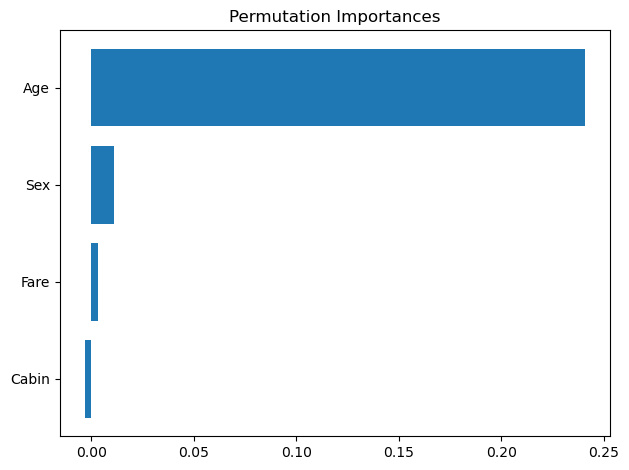

In [12]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(LR_pipe, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(FEATURES, result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [13]:
RFR_pipe = Pipeline([
    # -- IMPUTATION --
    ('missing_imputation', MissingBinaryTransformer(variables=['Cabin'])),
    ('missing_indicator', AddMissingIndicator(missing_only=True, variables=['Age'])),
    ('mean_imputation', MeanMedianImputer(imputation_method='median', variables=['Age'])),

    # -- TRANSFORMATION --
    ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
    ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
    ('log', LogTransformer(variables=['Fare'])),

    # -- SCALING AND PREDICTION -- 
    ('scaler', MinMaxScaler()),
    ('RandomForestRegressor', RandomForestRegressor()),],
    verbose = True)

In [14]:
RFR_pipe.fit(X_train, y_train)

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline]  (step 8 of 8) Processing RandomForestRegressor, total=   0.2s


Pipeline(steps=[('missing_imputation',
                 MissingBinaryTransformer(variables=['Cabin'])),
                ('missing_indicator', AddMissingIndicator(variables=['Age'])),
                ('mean_imputation', MeanMedianImputer(variables=['Age'])),
                ('gender_binarize', GenderBinaryTransformer(variables=['Sex'])),
                ('fare_nonzero', NonZeroTransformer(variables=['Fare'])),
                ('log', LogTransformer(variables=['Fare'])),
                ('scaler', MinMaxScaler()),
                ('RandomForestRegressor', RandomForestRegressor())],
         verbose=True)

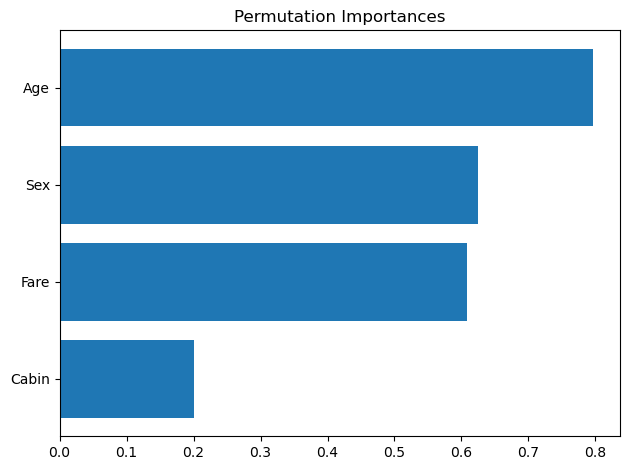

In [15]:
result = permutation_importance(RFR_pipe, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.barh(FEATURES, result.importances[sorted_idx].mean(axis=1).T)
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

### Grid Search

In [16]:
# Set grid search params
params = {
    'LogisticRegession':{
        'LogisticRegession__penalty': ['l1', 'l2'],
        'LogisticRegession__solver': ['liblinear', 'saga'],
        'LogisticRegession__random_state': [0, 1]},
    'RandomForestRegressor':{
        'RandomForestRegressor__max_features': [4], 
        'RandomForestRegressor__n_estimators': [3, 10, 30],}
}
jobs = -1
cross_validation = 10
gs_pipe = GridSearchCV(estimator = LR_pipe, 
                       param_grid = params['LogisticRegession'],
                       scoring = 'accuracy',
                       cv = cross_validation)
gs_pipe.fit(X_train, y_train)
# In[C] Best accuracy
print('Best accuracy: %.3f' % gs_pipe.best_score_)

# Best params
print('\nBest params:\n',gs_pipe.best_params_)

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline] . (step 8 of 8) Processing LogisticRegession, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipel

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline] . (step 8 of 8) Processing LogisticRegession, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipel

[Pipeline] . (step 8 of 8) Processing LogisticRegession, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline] . (step 8 of 8) Processing LogisticRegession, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipel

[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipeline] ............ (step 7 of 8) Processing scaler, total=   0.0s
[Pipeline] . (step 8 of 8) Processing LogisticRegession, total=   0.0s
[Pipeline]  (step 1 of 8) Processing missing_imputation, total=   0.0s
[Pipeline] . (step 2 of 8) Processing missing_indicator, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing mean_imputation, total=   0.0s
[Pipeline] ... (step 4 of 8) Processing gender_binarize, total=   0.0s
[Pipeline] ...... (step 5 of 8) Processing fare_nonzero, total=   0.0s
[Pipeline] ............... (step 6 of 8) Processing log, total=   0.0s
[Pipel

In [17]:
new_df = pd.read_csv(dataset_dir +'test.csv')
new_df.drop(['Name', 'Ticket'], axis=1, inplace=True)
X_valid = new_df[FEATURES]
X_valid

,Cabin,Fare,Sex,Age
0,NaN,7.8292,male,34.5
1,NaN,7.0000,female,47.0
2,NaN,9.6875,male,62.0
3,NaN,8.6625,male,27.0
4,NaN,12.2875,female,22.0
...,...,...,...,...
413,NaN,8.0500,male,NaN
414,C105,108.9000,female,39.0
415,NaN,7.2500,male,38.5
416,NaN,8.0500,male,NaN


In [18]:
missingdata_imputer = DropMissingData(variables=['Cabin'])

# fit the imputer
X_valid = missingdata_imputer.fit_transform(X_valid)
X_valid

,Cabin,Fare,Sex,Age
12,B45,82.2667,female,23.0
14,E31,61.1750,female,47.0
24,B57 B59 B63 B66,262.3750,female,48.0
26,B36,61.9792,female,22.0
28,A21,30.5000,male,41.0
...,...,...,...,...
404,D40,27.7208,male,43.0
405,D38,13.8625,male,20.0
407,C80,211.5000,male,50.0
411,C78,90.0000,female,37.0


In [19]:
# The only required code line to make the prediction using our pipeline

new_preds = LR_pipe.predict(X_valid)

In [20]:
result = pd.DataFrame(new_preds, columns=["Survived"])
result['PassengerId'] = new_df['PassengerId']
result.to_csv('result.csv', index=False)